In [2]:
from data_loader import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
train = load_data()

## Dataset shape

In [4]:
train.shape

(1460, 81)

## Variables

In [5]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

At the first glance, in column space we see **Id** column which doesn't takes part in model.  
Column **SalePrice** is depend variable; model objective is to predict future sales price for new unseen data.  
So we can split dataset for now:

In [6]:
train = train[train.columns.difference(['Id', 'SalePrice'])]

# Variable's categories

In [7]:
col_dtypes = train.dtypes
numeric_feats = col_dtypes[col_dtypes != 'object'].axes[0].tolist()
categoric_feats = col_dtypes[col_dtypes == 'object'].axes[0].tolist()
print(f'Numeric var space:   {len(numeric_feats)}')
print(f'Categoric var space: {len(categoric_feats)}')

Numeric var space:   36
Categoric var space: 43


Numeric variable are both continuous and discrete (we could make discrete categoric vars if it's desireable for model accuracy)     
For model is important to transform categorical variables for dummy variables (one-hot encoding)   
In order to keep feature space not to large (prevent curse of dimensionality), features which are ordinal could be replaced with simple encoding by integers (with respect to order of values)

## Numercial varibles

### Missing values
Identification missing values and choosing right replacement strategy

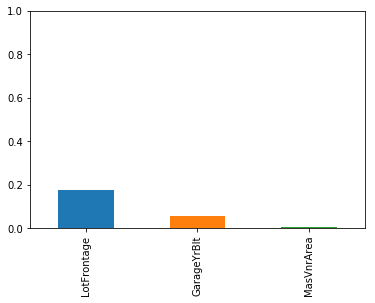

In [8]:
nan_numeric_info = train[numeric_feats].isnull().sum()
nan_numeric_feats = nan_numeric_info[nan_numeric_info>0]
nan_numeric_feats.apply(lambda x: x/train.shape[0]).sort_values(ascending=False).plot(kind='bar', ylim=(0, 1))

In [14]:
GarageYrBlt_null_idx = train['GarageYrBlt'].isnull()


In [17]:
MasVnrArea_null_idx = train['MasVnrArea'].isnull()
train[MasVnrArea_null_idx]['MasVnrType'].unique()

array([nan], dtype=object)

1. LotFrontage is strong correlated with LotArea (look at notebook 1.2.1). Since imputing with mean or mode or zero gives bad results (such imputed values doesn't follow correlation), it seems feasible to impute with regression (predict missing) or drop this feature (due to belief, that LotFrontage is reduntant to LotArea in order to correlation with LotArea). Best imputation will be checked during model selection  
2. GarageYrBlt missing values are at random, so they may be set to 0, since it will vanish its term in regression  
3. MasVnrArea is set to NaN only when there is no masonry type specified

In [24]:
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)

## Categorical variables

### Missing values
Identification missing values and choosing right replacement strategy

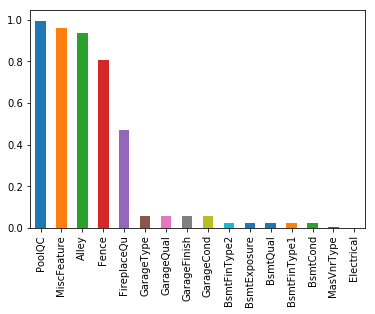

In [25]:
nan_categoric_info = train[categoric_feats].isnull().sum()
nan_categoric_feats = nan_categoric_info[nan_categoric_info>0]
if not nan_categoric_feats.empty:
    nan_categoric_feats.apply(lambda x: x/train.shape[0]).sort_values(ascending=False).plot(kind='bar')
else:
    print("No missing value in such range")

1. Most of missing features presented above  are missing when there is no such feature in the house (like no pool, no basement, no garage, no masonry), so they could be replaced with value like "None"
2. Missing in electrical is random, it could be replace e.g. with mode or we could do some more insight into this example (for purpose of delete this example, when classified as outlier)

In [26]:
#Some replacement are done due to documentation specification of possible missing values
nan_to_none_cat_feats = ['PoolQC','MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure', 'BsmtCond', 'MasVnrType']
train[nan_to_none_cat_feats] = train[nan_to_none_cat_feats].fillna('None')
#Electrical are no specifide to has missing values, I replace it with median
nan_to_mode_cat_feats = ['Electrical']
train[nan_to_mode_cat_feats] = train[nan_to_mode_cat_feats].fillna(train['Electrical'].mode()[0])

### Oridnal features
Ordinal features are feasible for replacing them with specified value with correct order.
Handcrafted mappers ensures that there is no order violation during mapping (e.g. using automtic from sklearn)
#### NOTES:
1. Since it's quite reasonable to handle mapping with own-designeg mappers (for keep correct order), it's intractable to perform mapping during working with model (validation using pipelines have to do all this job "on the fly" to prevent data leakage)
2. Mapping should always keep the rule of encoding values which aren't present in train set (e.g. train fold in cross-validation), and such handcrafted mappers doesn't follow this rule
3. Solution for above problem is to use e.g. sklearn.LabelEncoder

In [27]:
BsmtCond_encode = BsmtQual_encode = ExterCond_encode = ExterQual_encode = FireplaceQu_encode = GarageCond_encode = \
GarageQual_encode = HeatingQC_encode = KitchenQual_encode = PoolQC_encode = {'None':0, 'Po':1, 'Fa':2, 'TA':3,  'Gd':4, 'Ex':5}
Alley_encode = {'None': 0, 'Grlv': 1, 'Pave': 2}
BsmtExposure_encode= {'None':0, 'No':0, 'Mn':1, 'Av':2, 'Gd':3}
BsmtFinType1_encode = BsmtFinType2_encode= {'None':0,'Unf':1,'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5,'GLQ':6}
Fence_encode = {'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}
PavedDrive_encode = {'N':0, 'P':1, 'Y':2}
LotShape_encode = {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3}#could replace all irregularities with one
LandSlope_encodeg = {'Sev':1, 'Mod':2, 'Gtl':3}
Utilities_encode = {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}
Electrical_encode= {'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5}
Functional_encode = {'Sal':0, 'Sev':1, 'Maj1':2, 'Maj2':3, 'Mod':4, 'Min1':5, 'Min2':6, 'Typ':7}
GarageFinish_encode = {'None':0, 'Unf':1, 'RFn':2, 'Fin':3}

In [28]:
ordinal_cat_feats = ['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'ExterCond' , \
                    'ExterQual', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond','GarageQual', 'HeatingQC', 'KitchenQual',\
                     'PavedDrive','Utilities','LotShape', 'LandSlope', 'Electrical', 'PoolQC', 'GarageFinish']
ordinal_cat_encoders = {'Alley':Alley_encode, 'BsmtCond':BsmtCond_encode, 'BsmtQual':BsmtQual_encode,\
                        'BsmtExposure':BsmtExposure_encode, 'BsmtFinType1':BsmtFinType1_encode,\
                        'BsmtFinType2':BsmtFinType2_encode,'ExterCond': ExterCond_encode, 'ExterQual':ExterQual_encode,\
                        'FireplaceQu':FireplaceQu_encode, 'Functional':Functional_encode, 'GarageCond':GarageCond_encode,\
                        'HeatingQC':HeatingQC_encode, 'KitchenQual':KitchenQual_encode, 'PavedDrive':PavedDrive_encode,\
                        'Utilities':Utilities_encode,'LotShape':LotShape_encode, 'LandSlope':LandSlope_encodeg,\
                        'Electrical':Electrical_encode, 'PoolQC':PoolQC_encode, 'GarageFinish':GarageFinish_encode,\
                        'Fence':Fence_encode, 'GarageQual':GarageQual_encode}

### Nominal features

In [29]:
nominal_cat_feats = [x for x in categoric_feats if x not in ordinal_cat_feats]
print(nominal_cat_feats)

['BldgType', 'CentralAir', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street']
